## Setup

### Installations

In [8]:
pip install numpy

Note: you may need to restart the kernel to use updated packages.


In [9]:
pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [10]:
pip install scipy

Note: you may need to restart the kernel to use updated packages.


In [11]:
pip install pandas

Note: you may need to restart the kernel to use updated packages.


In [12]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [13]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.


### Imports

In [1720]:
import seaborn as sns
import pandas as pd
import torch
import os
from scipy import io as sio
from sklearn.model_selection import train_test_split
import numpy as np

### Loading Data

In [1721]:
#load data
data_dir_root = os.path.join('./data', 'ThingsEEG-Text')
sbj = 'sub-10'
image_model = 'pytorch/cornet_s'
text_model = 'CLIPText'
roi = '17channels'
brain_dir = os.path.join(data_dir_root, 'brain_feature', roi, sbj)
image_dir_seen = os.path.join(data_dir_root, 'visual_feature/ThingsTrain', image_model, sbj)
image_dir_unseen = os.path.join(data_dir_root, 'visual_feature/ThingsTest', image_model, sbj)
text_dir_seen = os.path.join(data_dir_root, 'textual_feature/ThingsTrain/text', text_model, sbj)
text_dir_unseen = os.path.join(data_dir_root, 'textual_feature/ThingsTest/text', text_model, sbj)

brain_seen = sio.loadmat(os.path.join(brain_dir, 'eeg_train_data_within.mat'))['data'].astype('double') * 2.0
brain_seen_copy = brain_seen
brain_seen = brain_seen[:,:,27:60] # 70ms-400ms
outside_brain_1 = brain_seen_copy[:, :, 0:27]
outside_brain_2 = brain_seen_copy[:, :, 60:]
brain_seen_copy = np.reshape(brain_seen_copy, (brain_seen_copy.shape[0], -1))
brain_seen = np.reshape(brain_seen, (brain_seen.shape[0], -1))
outside_brain_1 = np.reshape(outside_brain_1, (outside_brain_1.shape[0], -1))
outside_brain_2 = np.reshape(outside_brain_2, (outside_brain_2.shape[0], -1))
image_seen = sio.loadmat(os.path.join(image_dir_seen, 'feat_pca_train.mat'))['data'].astype('double')*50.0
text_seen = sio.loadmat(os.path.join(text_dir_seen, 'text_feat_train.mat'))['data'].astype('double')*2.0
label_seen = sio.loadmat(os.path.join(brain_dir, 'eeg_train_data_within.mat'))['class_idx'].T.astype('int')
image_seen_copy = image_seen
image_seen = image_seen[:,0:100]

brain_unseen = sio.loadmat(os.path.join(brain_dir, 'eeg_test_data.mat'))['data'].astype('double')*2.0
brain_unseen_copy = brain_unseen
brain_unseen = brain_unseen[:, :, 27:60]
brain_unseen_copy = np.reshape(brain_unseen_copy, (brain_unseen_copy.shape[0], -1))
brain_unseen = np.reshape(brain_unseen, (brain_unseen.shape[0], -1))
image_unseen = sio.loadmat(os.path.join(image_dir_unseen, 'feat_pca_test.mat'))['data'].astype('double')*50.0
text_unseen = sio.loadmat(os.path.join(text_dir_unseen, 'text_feat_test.mat'))['data'].astype('double')*2.0
label_unseen = sio.loadmat(os.path.join(brain_dir, 'eeg_test_data.mat'))['class_idx'].T.astype('int')
image_unseen_copy = image_unseen
image_unseen = image_unseen[:, 0:100]

brain_seen = torch.from_numpy(brain_seen)
brain_unseen = torch.from_numpy(brain_unseen)
outside_brain_1 = torch.from_numpy(outside_brain_1)
outside_brain_2 = torch.from_numpy(outside_brain_2)
image_seen = torch.from_numpy(image_seen)
image_unseen = torch.from_numpy(image_unseen)
text_seen = torch.from_numpy(text_seen)
text_unseen = torch.from_numpy(text_unseen)
label_seen = torch.from_numpy(label_seen)
label_unseen = torch.from_numpy(label_unseen)

## Data Exploration

In [1722]:
print('seen_brain_samples=', brain_seen.shape[0], ', seen_brain_features=', brain_seen.shape[1], ', seen_brain_total_features=', brain_seen_copy.shape[1])
print('seen_image_samples=', image_seen.shape[0], ', seen_image_features=', image_seen.shape[1], ', seen_image_total_features=', image_seen_copy.shape[1])
print('seen_text_samples=', text_seen.shape[0], ', seen_text_features=', text_seen.shape[1])
print('seen_label=', label_seen.shape)
print('unseen_brain_samples=', brain_unseen.shape[0], ', unseen_brain_features=', brain_unseen.shape[1], ', unseen_brain_total_features=', brain_unseen_copy.shape[1])
print('unseen_image_samples=', image_unseen.shape[0], ', unseen_image_features=', image_unseen.shape[1], ', unseen_image_total_features=', image_unseen_copy.shape[1])
print('unseen_text_samples=', text_unseen.shape[0], ', unseen_text_features=', text_unseen.shape[1])
print('unseen_label=', label_unseen.shape)

seen_brain_samples= 16540 , seen_brain_features= 561 , seen_brain_total_features= 1700
seen_image_samples= 16540 , seen_image_features= 100 , seen_image_total_features= 1000
seen_text_samples= 16540 , seen_text_features= 512
seen_label= torch.Size([16540, 1])
unseen_brain_samples= 16000 , unseen_brain_features= 561 , unseen_brain_total_features= 1700
unseen_image_samples= 16000 , unseen_image_features= 100 , unseen_image_total_features= 1000
unseen_text_samples= 16000 , unseen_text_features= 512
unseen_label= torch.Size([16000, 1])


In [1723]:
def count_images_per_class(labels):
    unique, counts = torch.unique(labels, return_counts=True)
    class_counts = dict(zip(unique.tolist(), counts.tolist()))
    return class_counts

In [1724]:
seen_images_count = count_images_per_class(label_seen)
unseen_images_count = count_images_per_class(label_unseen)
print(f'Class distribution of label seen: {seen_images_count}')
print(f'Class distribution of label unseen: {unseen_images_count}')

Class distribution of label seen: {1: 10, 2: 10, 3: 10, 4: 10, 5: 10, 6: 10, 7: 10, 8: 10, 9: 10, 10: 10, 11: 10, 12: 10, 13: 10, 14: 10, 15: 10, 16: 10, 17: 10, 18: 10, 19: 10, 20: 10, 21: 10, 22: 10, 23: 10, 24: 10, 25: 10, 26: 10, 27: 10, 28: 10, 29: 10, 30: 10, 31: 10, 32: 10, 33: 10, 34: 10, 35: 10, 36: 10, 37: 10, 38: 10, 39: 10, 40: 10, 41: 10, 42: 10, 43: 10, 44: 10, 45: 10, 46: 10, 47: 10, 48: 10, 49: 10, 50: 10, 51: 10, 52: 10, 53: 10, 54: 10, 55: 10, 56: 10, 57: 10, 58: 10, 59: 10, 60: 10, 61: 10, 62: 10, 63: 10, 64: 10, 65: 10, 66: 10, 67: 10, 68: 10, 69: 10, 70: 10, 71: 10, 72: 10, 73: 10, 74: 10, 75: 10, 76: 10, 77: 10, 78: 10, 79: 10, 80: 10, 81: 10, 82: 10, 83: 10, 84: 10, 85: 10, 86: 10, 87: 10, 88: 10, 89: 10, 90: 10, 91: 10, 92: 10, 93: 10, 94: 10, 95: 10, 96: 10, 97: 10, 98: 10, 99: 10, 100: 10, 101: 10, 102: 10, 103: 10, 104: 10, 105: 10, 106: 10, 107: 10, 108: 10, 109: 10, 110: 10, 111: 10, 112: 10, 113: 10, 114: 10, 115: 10, 116: 10, 117: 10, 118: 10, 119: 10, 12

### Charts

In [1725]:
import matplotlib.pyplot as plt

#### Histogram

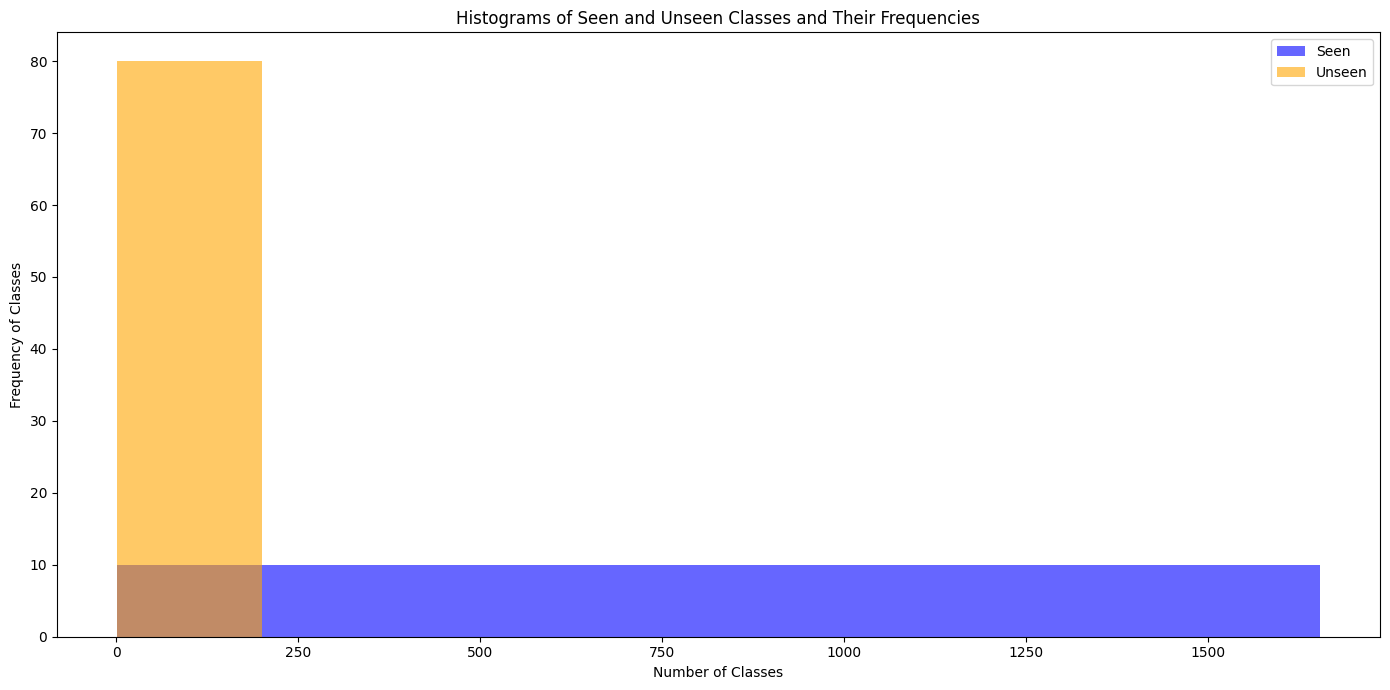

In [1726]:
seen_classes = list(seen_images_count.keys())
seen_frequencies = list(seen_images_count.values())

unseen_classes = list(unseen_images_count.keys())
unseen_frequencies = list(unseen_images_count.values())

# Plotting histograms
plt.figure(figsize=(14, 7))

# Plot for seen classes
plt.hist(seen_classes, bins=len(seen_classes), weights=seen_frequencies, color='blue', label='Seen', alpha=0.6)

# Plot for unseen classes
plt.hist(unseen_classes, bins=len(unseen_classes), weights=unseen_frequencies, color='orange', label='Unseen', alpha=0.6)

# Adding labels and title
plt.xlabel('Number of Classes')
plt.ylabel('Frequency of Classes')
plt.title('Histograms of Seen and Unseen Classes and Their Frequencies')
plt.legend()
plt.tight_layout()

# Show the plot
plt.show()

#### Pie Charts

In [1727]:
def pie_chart_comparison(seen, unseen):
    sizes = [seen.shape[0], unseen.shape[0]]
    labels = ['Seen', 'Unseen']

    plt.figure(figsize=(8, 8))
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=['skyblue', 'orange'])
    plt.title('Comparison of Total Samples (Seen vs. Unseen)')
    plt.show()

In [1728]:
def comparison_of_sample_images(seen, unseen):
    sizes = [seen[1], unseen[1]]
    labels = ['Seen', 'Unseen']

    # Plot pie chart
    plt.figure(figsize=(8, 8))
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=['skyblue', 'orange'])
    plt.title('Comparison of Single Class Size (Seen vs. Unseen)')
    plt.show()

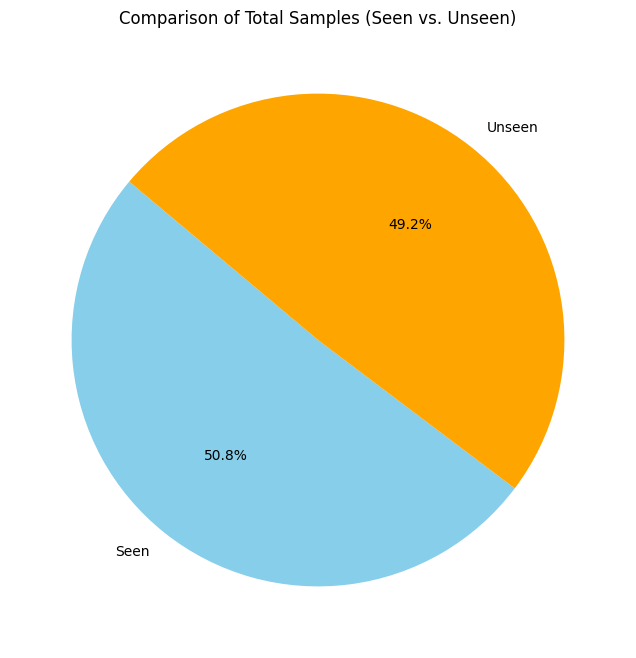

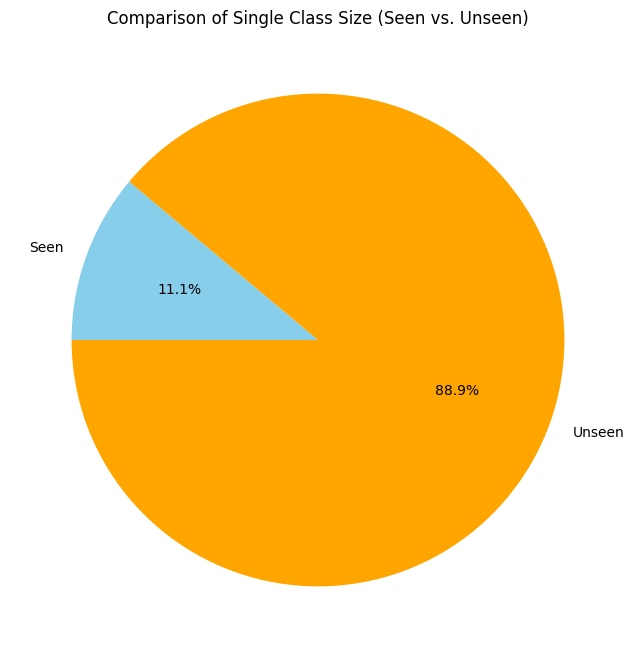

In [1729]:
pie_chart_comparison(image_seen, image_unseen)
comparison_of_sample_images(seen_images_count, unseen_images_count)

## Data Pre-processing

### Splitting Data

In [1730]:
# For seen and unseen categories

stratified = False

desired_categories = 50

index_seen = np.squeeze(np.where(label_seen < desired_categories + 1, True, False))
index_unseen = np.squeeze(np.where(label_unseen < desired_categories + 1, True, False))
brain_seen = brain_seen[index_seen, :]
image_seen = image_seen[index_seen, :]
text_seen = text_seen[index_seen, :]
label_seen = label_seen[index_seen]
brain_unseen = brain_unseen[index_unseen, :]
image_unseen = image_unseen[index_unseen, :]
text_unseen = text_unseen[index_unseen, :]
label_unseen = label_unseen[index_unseen]
num_classes = desired_categories
samples_per_class = 10

_brain = torch.cat((brain_seen, brain_unseen), dim=0)
_text = torch.cat((text_seen, text_unseen), dim=0)
_image = torch.cat((image_seen, image_unseen), dim=0)
_label = torch.cat((label_seen, label_unseen), dim=0)


if stratified:
    (
    train_brain, test_brain,
    train_text, test_text,
    train_image, test_image,
    train_label, test_label,
    ) = train_test_split(
    _brain, _text, _image, _label,
    test_size=0.6,
    stratify=_label,
    random_state=42 
    )

else:
    split = 4

    new_train_brain = []
    new_train_image = []
    new_train_text = []
    new_train_label = []

    new_test_brain = []
    new_test_image = []
    new_test_text = []
    new_test_label = []

    for i in range(num_classes):
        start_idx = i * samples_per_class#The starting index of the current class
        end_idx = start_idx + samples_per_class#The end index of the current class
        #Get the data of the current class
        class_data_brain = _brain[start_idx:end_idx, :]
        #Divided into training set and test set
        new_train_brain.append(class_data_brain[:split])
        new_test_brain.append(class_data_brain[split:])

        class_data_image = _image[start_idx:end_idx, :]

        new_train_image.append(class_data_image[:split])
        new_test_image.append(class_data_image[split:])

        class_data_text = _text[start_idx:end_idx, :]

        new_train_text.append(class_data_text[:split])
        new_test_text.append(class_data_text[split:])

        class_data_label = _label[start_idx:end_idx, :]

        new_train_label.append(class_data_label[:split])
        new_test_label.append(class_data_label[split:])

    train_brain = torch.vstack(new_train_brain)
    train_image = torch.vstack(new_train_image)
    train_text = torch.vstack(new_train_text)
    train_label = torch.vstack(new_train_label)
    test_brain = torch.vstack(new_test_brain)
    test_image = torch.vstack(new_test_image)
    test_text = torch.vstack(new_test_text)
    test_label = torch.vstack(new_test_label)

In [1731]:
# Just for seen categories
"""
stratified = False

desired_categories = 100

index_seen = np.squeeze(np.where(label_seen < desired_categories + 1, True, False))
brain_seen = brain_seen[index_seen, :]
image_seen = image_seen[index_seen, :]
text_seen = text_seen[index_seen, :]
label_seen = label_seen[index_seen]
num_classes = desired_categories
samples_per_class = 10

if stratified:
    (
    train_brain, test_brain,
    train_text, test_text,
    train_image, test_image,
    train_label, test_label,
    ) = train_test_split(
    brain_seen, text_seen, image_seen, label_seen,
    test_size=0.6,
    stratify=label_seen,
    random_state=42 
    )

else:
    split = 4

    new_train_brain = []
    new_train_image = []
    new_train_text = []
    new_train_label = []

    new_test_brain = []
    new_test_image = []
    new_test_text = []
    new_test_label = []

    for i in range(num_classes):
        start_idx = i * samples_per_class#The starting index of the current class
        end_idx = start_idx + samples_per_class#The end index of the current class
        #Get the data of the current class
        class_data_brain = brain_seen[start_idx:end_idx, :]
        #Divided into training set and test set
        new_train_brain.append(class_data_brain[:split])
        new_test_brain.append(class_data_brain[split:])

        class_data_image = image_seen[start_idx:end_idx, :]

        new_train_image.append(class_data_image[:split])
        new_test_image.append(class_data_image[split:])

        class_data_text = text_seen[start_idx:end_idx, :]

        new_train_text.append(class_data_text[:split])
        new_test_text.append(class_data_text[split:])

        class_data_label = label_seen[start_idx:end_idx, :]

        new_train_label.append(class_data_label[:split])
        new_test_label.append(class_data_label[split:])

    train_brain = torch.vstack(new_train_brain)
    train_image = torch.vstack(new_train_image)
    train_text = torch.vstack(new_train_text)
    train_label = torch.vstack(new_train_label)
    test_brain = torch.vstack(new_test_brain)
    test_image = torch.vstack(new_test_image)
    test_text = torch.vstack(new_test_text)
    test_label = torch.vstack(new_test_label)
"""

'\nstratified = False\n\ndesired_categories = 100\n\nindex_seen = np.squeeze(np.where(label_seen < desired_categories + 1, True, False))\nbrain_seen = brain_seen[index_seen, :]\nimage_seen = image_seen[index_seen, :]\ntext_seen = text_seen[index_seen, :]\nlabel_seen = label_seen[index_seen]\nnum_classes = desired_categories\nsamples_per_class = 10\n\nif stratified:\n    (\n    train_brain, test_brain,\n    train_text, test_text,\n    train_image, test_image,\n    train_label, test_label,\n    ) = train_test_split(\n    brain_seen, text_seen, image_seen, label_seen,\n    test_size=0.6,\n    stratify=label_seen,\n    random_state=42 \n    )\n\nelse:\n    split = 4\n\n    new_train_brain = []\n    new_train_image = []\n    new_train_text = []\n    new_train_label = []\n\n    new_test_brain = []\n    new_test_image = []\n    new_test_text = []\n    new_test_label = []\n\n    for i in range(num_classes):\n        start_idx = i * samples_per_class#The starting index of the current class\n   

In [1732]:
print(train_brain.shape)
print(train_image.shape)
print(train_text.shape)
print(train_label.shape)
print(test_brain.shape)
print(test_image.shape)
print(test_text.shape)
print(test_label.shape)

torch.Size([200, 561])
torch.Size([200, 100])
torch.Size([200, 512])
torch.Size([200, 1])
torch.Size([300, 561])
torch.Size([300, 100])
torch.Size([300, 512])
torch.Size([300, 1])


### Normalising Data

In [1733]:
def do_normalisation(training_modality, testing_modality):
    _max = torch.max(training_modality)
    _min = torch.min(training_modality)

    training_normalised = (training_modality - _min) / (_max - _min)
    testing_normalised = (testing_modality - _min) / (_max - _min)

    return training_normalised, testing_normalised

In [1734]:
train_brain, test_brain = do_normalisation(train_brain, test_brain)
train_text, test_text = do_normalisation(train_text, test_text)
train_image, test_image = do_normalisation(train_image, test_image)

### Dimension Reduction

#### PCA Decomp

In [1735]:
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt

def do_pca(modality, modality2, modality_label):
    pca = PCA()
    pca.fit(modality)

    evr_modality = pca.explained_variance_ratio_
    evr_modality_cum = np.cumsum(evr_modality)

    plt.plot(evr_modality_cum)
    plt.title(f'Cumulative Explained Variance for {modality_label}')
    plt.xlabel('Number of Features')
    plt.ylabel('Cumulative Explained Variance')
    plt.show()

    no_features = np.argmax(evr_modality_cum >= 0.95) + 1
    print(f'For {modality_label}, number of features that explains 95% variance: {no_features}')

    pca1 = PCA(n_components=no_features)
    pca1.fit(modality)

    modality_reduced = pca1.transform(modality)
    modality2_recduced = pca1.transform(modality2)

    return torch.from_numpy(modality_reduced), torch.from_numpy(modality2_recduced)

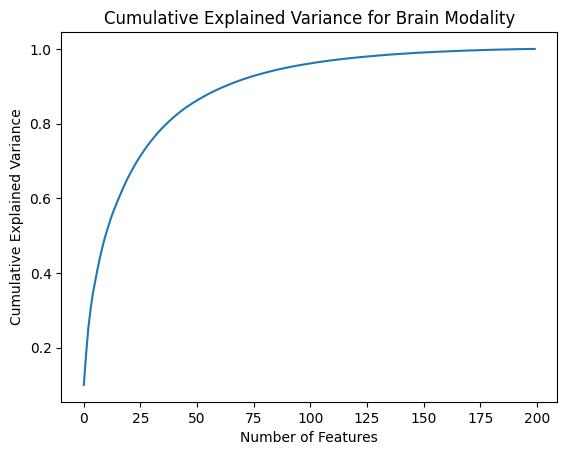

For Brain Modality, number of features that explains 95% variance: 91


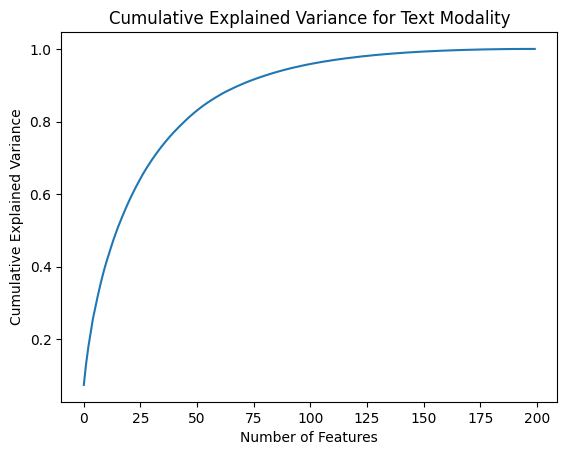

For Text Modality, number of features that explains 95% variance: 95


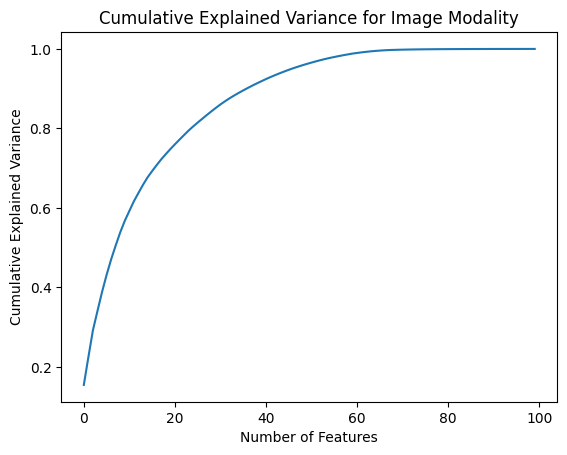

For Image Modality, number of features that explains 95% variance: 47


In [1736]:
# PCA one-by-one then combine
train_brain, test_brain = do_pca(train_brain, test_brain, 'Brain Modality')
train_text, test_text = do_pca(train_text, test_text, 'Text Modality')
train_image, test_image = do_pca(train_image, test_image, 'Image Modality')

#### Fuse Features

In [1737]:
train_label = train_label.numpy().ravel()
test_label = test_label.numpy().ravel()
train_set = np.hstack([train_brain, train_text, train_image])
test_set = np.hstack([test_brain, test_text, test_image])

#### LDA Decomp

In [1738]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis()

In [1739]:
training_set = lda.fit_transform(train_set, train_label)
testing_set = lda.transform(test_set)

## Implementations

### Sklearn Baseline

In [1740]:
from sklearn.linear_model import LogisticRegression

skmodel = LogisticRegression()
skmodel.fit(train_set, train_label)
skpredictions = skmodel.predict(test_set)

### Basic Implementation

In [1741]:
class BasicLogisticRegression:
    def __init__(self, learning_rate=0.01, num_iterations=1000):
        self.learning_rate = learning_rate
        self.num_iterations = num_iterations
        self.weights = None
        self.classes = None

    def sigmoid_function(self, z):
        result = 1 / (1 + np.exp(-z))
        return result

    def gradient_descent(self, training_set, binary_labels, weights):
        m = training_set.shape[0]
        losses = []  # To store the loss at each iteration
        for i in range(self.num_iterations):
            z = np.dot(training_set, weights)
            predictions = self.sigmoid_function(z)
            loss = -np.mean(binary_labels * np.log(predictions + 1e-15) + (1 - binary_labels) * np.log(1 - predictions + 1e-15))
            losses.append(loss)
            gradient = np.dot(training_set.T, (predictions - binary_labels)) / m
            weights -= self.learning_rate * gradient
            
        return weights, losses

    def fit(self, training_set, train_labels):
        self.classes = np.unique(train_labels)
        n_features = training_set.shape[1]
        self.weights = {}
        self.losses = {}  # Store loss for each class

        for c in self.classes:
            binary_labels = np.where(train_labels == c, 1, 0)
            weights = np.zeros(n_features)
            self.weights[c], losses = self.gradient_descent(training_set, binary_labels, weights)
            self.losses[c] = losses

    def predict_probability(self, testing_set):
        probabilities = {}
        for c, weights in self.weights.items():
            z = np.dot(testing_set, weights)
            probabilities[c] = self.sigmoid_function(z)
        return np.column_stack([probabilities[c] for c in self.classes])

    def predict(self, testing_set):
        probabilities = self.predict_probability(testing_set)
        result = self.classes[np.argmax(probabilities, axis=1)]
        return result

In [1742]:
basicmodel = BasicLogisticRegression(0.01, 1000)
basicmodel.fit(training_set, train_label)

basicpredictions = basicmodel.predict(testing_set)

### Improved Implementation

In [1743]:
class ImprovedLogisticRegression:
    def __init__(self, learning_rate=0.01, num_iterations=1000):
        self.learning_rate = learning_rate
        self.num_iterations = num_iterations
        self.weights = None
        self.bias = None

    def softmax_function(self, z):
        exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
        result = exp_z / np.sum(exp_z, axis=1, keepdims=True)
        return result

    def one_hot_encode(self, train_label, num_classes):
        one_hot = np.zeros((train_label.shape[0], num_classes))
        one_hot[np.arange(train_label.shape[0]), train_label] = 1
        return one_hot

    def fit(self, training_set, train_label):
        num_samples, num_features = training_set.shape
        num_classes = np.max(train_label) + 1

        self.weights = np.zeros((num_features, num_classes))
        self.bias = np.zeros((1, num_classes))

        train_label_one_hot = self.one_hot_encode(train_label, num_classes)

        for i in range(self.num_iterations):
            logits = np.dot(training_set, self.weights) + self.bias
            probs = self.softmax_function(logits)

            gradient_w = np.dot(training_set.T, (probs - train_label_one_hot)) / num_samples
            gradient_b = np.sum(probs - train_label_one_hot, axis=0, keepdims=True) / num_samples

            self.weights -= self.learning_rate * gradient_w
            self.bias -= self.learning_rate * gradient_b

    def predict(self, testing_set):
        logits = np.dot(testing_set, self.weights) + self.bias
        probs = self.softmax_function(logits)
        result = np.argmax(probs, axis=1)
        return result

In [1744]:
improvedmodel = ImprovedLogisticRegression(0.01, 1000)
improvedmodel.fit(training_set, train_label)

improvedpredictions = improvedmodel.predict(testing_set)

### Performance

#### Metrics

In [1745]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

In [1746]:
def calc_f1(true, predicted, modelname):
    f1_micro = f1_score(true, predicted, average='micro')
    f1_macro = f1_score(true, predicted, average='macro')
    f1_weighted = f1_score(true, predicted, average='weighted')

    print(f"{modelname} Micro F1 Score: {f1_micro}")
    print(f"{modelname} Macro F1 Score: {f1_macro}")
    print(f"{modelname} Weighted F1 Score: {f1_weighted}")

def calc_precision(true, predicted, modelname):
    pr_micro = precision_score(true, predicted, average='micro')
    pr_macro = precision_score(true, predicted, average='macro')
    pr_weighted = precision_score(true, predicted, average='weighted')

    print(f"{modelname} Micro Precision Score: {pr_micro}")
    print(f"{modelname} Macro Precision Score: {pr_macro}")
    print(f"{modelname} Weighted Precision Score: {pr_weighted}")

def calc_recall(true, predicted, modelname):
    re_micro = recall_score(true, predicted, average='micro')
    re_macro = recall_score(true, predicted, average='macro')
    re_weighted = recall_score(true, predicted, average='weighted')
    #re_none = recall_score(true, predicted, average=None)

    print(f"{modelname} Micro Recall Score: {re_micro}")
    print(f"{modelname} Macro Recall Score: {re_macro}")
    print(f"{modelname} Weighted Recall Score: {re_weighted}")
    #print(f"{modelname} Recall Score: {re_none}")

def calc_accuracy(true, predicted, modelname):
    ac = accuracy_score(true, predicted)

    print(f"{modelname} Accuracy Score: {ac}")

In [1747]:
calc_f1(test_label, skpredictions, "Sk model")
calc_precision(test_label, skpredictions, "Sk model")
calc_recall(test_label, skpredictions, "Sk model")
calc_accuracy(test_label, skpredictions, "Sk model")

Sk model Micro F1 Score: 0.6566666666666666
Sk model Macro F1 Score: 0.6436388807271161
Sk model Weighted F1 Score: 0.643638880727116
Sk model Micro Precision Score: 0.6566666666666666
Sk model Macro Precision Score: 0.6592597402597403
Sk model Weighted Precision Score: 0.6592597402597403
Sk model Micro Recall Score: 0.6566666666666666
Sk model Macro Recall Score: 0.6566666666666667
Sk model Weighted Recall Score: 0.6566666666666666
Sk model Accuracy Score: 0.6566666666666666


In [1748]:
calc_f1(test_label, basicpredictions, "Basic model")
calc_precision(test_label, basicpredictions, "Basic model")
calc_recall(test_label, basicpredictions, "Basic model")
calc_accuracy(test_label, basicpredictions, "Basic model")

Basic model Micro F1 Score: 0.7333333333333333
Basic model Macro F1 Score: 0.7130463849875613
Basic model Weighted F1 Score: 0.7130463849875616
Basic model Micro Precision Score: 0.7333333333333333
Basic model Macro Precision Score: 0.7754329004329005
Basic model Weighted Precision Score: 0.7754329004329005
Basic model Micro Recall Score: 0.7333333333333333
Basic model Macro Recall Score: 0.7333333333333334
Basic model Weighted Recall Score: 0.7333333333333333
Basic model Accuracy Score: 0.7333333333333333


In [1749]:
calc_f1(test_label, improvedpredictions, "Improved model")
calc_precision(test_label, improvedpredictions, "Improved model")
calc_recall(test_label, improvedpredictions, "Improved model")
calc_accuracy(test_label, improvedpredictions, "Improved model")

Improved model Micro F1 Score: 0.7566666666666667
Improved model Macro F1 Score: 0.7417018667606904
Improved model Weighted F1 Score: 0.7417018667606903
Improved model Micro Precision Score: 0.7566666666666667
Improved model Macro Precision Score: 0.7674761904761905
Improved model Weighted Precision Score: 0.7674761904761904
Improved model Micro Recall Score: 0.7566666666666667
Improved model Macro Recall Score: 0.7566666666666667
Improved model Weighted Recall Score: 0.7566666666666667
Improved model Accuracy Score: 0.7566666666666667


In [1750]:
def plot_perf_scores(f1_scores, precision_scores, accuracy_scores, modelname):
    intervals = [20, 50, 100, 150, 200, 250, 300]

    plt.figure(figsize=(10, 6))
    plt.plot(intervals, f1_scores, marker='o', label='F1-Score', linestyle='-')
    plt.plot(intervals, precision_scores, marker='s', label='Precision-Score', linestyle='--')
    plt.plot(intervals, accuracy_scores, marker='^', label='Accuracy-Score', linestyle='-.')

    plt.xlabel('Number of Samples')
    plt.ylabel('Scores')
    plt.title(f'Performance Metrics For {modelname}')

    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.legend()
    plt.tight_layout()
    plt.show()

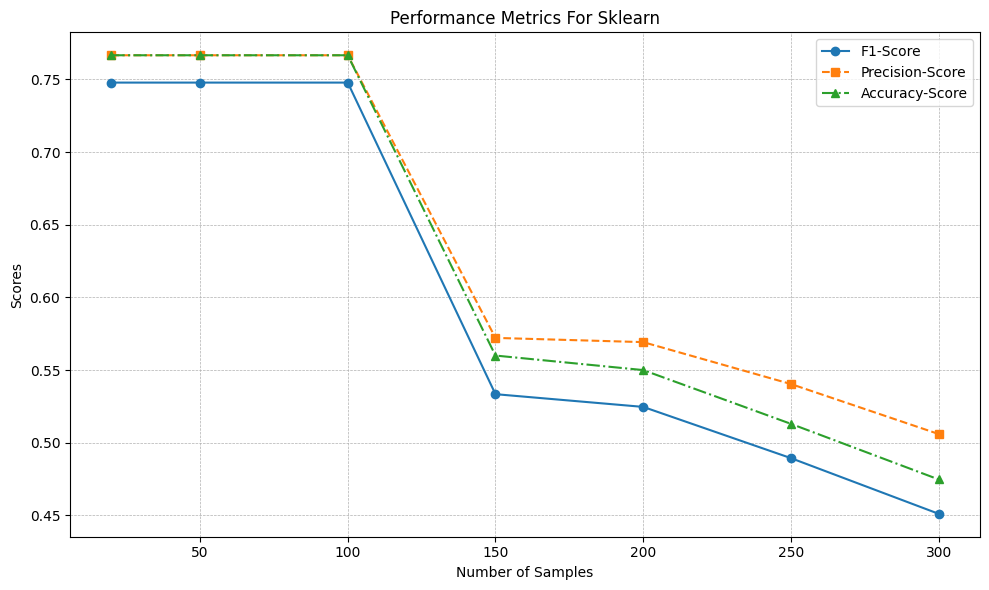

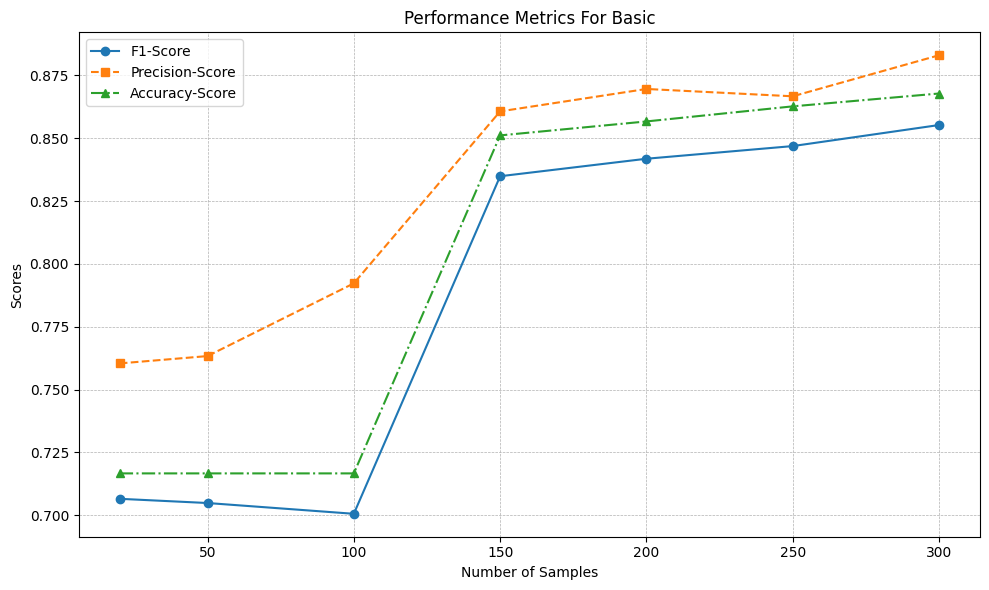

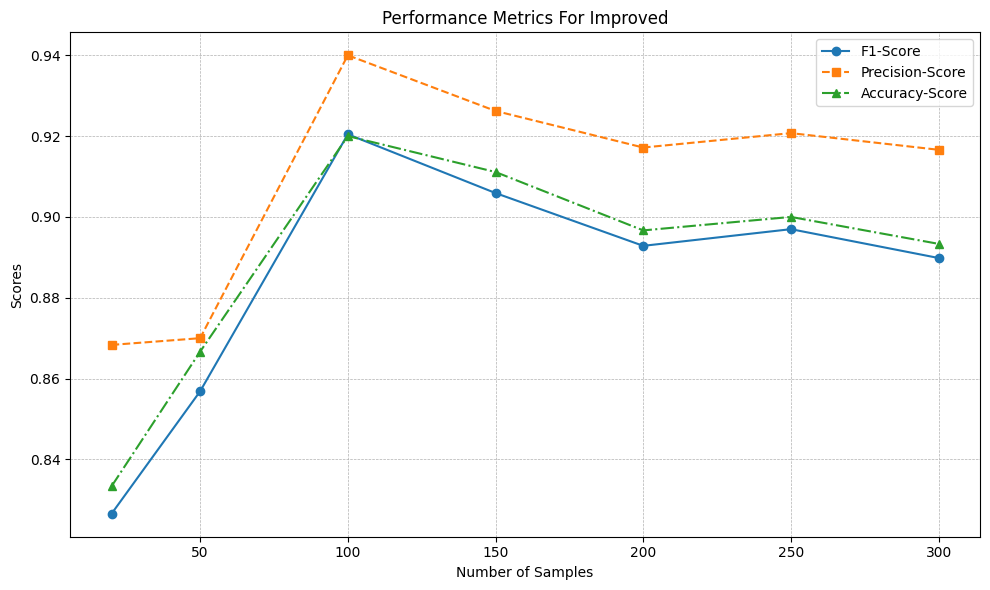

In [1751]:
plot_perf_scores([0.747857, 0.747857, 0.7478571, 0.5334186, 0.5246616, 0.4894049, 0.45109], [0.76666667, 0.76666667, 0.76666667, 0.5721507, 0.56923863, 0.5404, 0.506], [0.76666667, 0.76666667, 0.7666667, 0.56, 0.55, 0.513, 0.47474], "Sklearn")
plot_perf_scores([0.706558, 0.7048809, 0.700595, 0.834873, 0.841829, 0.846863, 0.855238], [0.76041666, 0.763333334, 0.7922619, 0.86066667, 0.8695833, 0.86666667, 0.88299], [0.716666666, 0.71666666, 0.716666666, 0.85111111, 0.856666667, 0.86266666, 0.86777777777], "Basic")
plot_perf_scores([0.8265476, 0.8568571428571428, 0.9204523809523808, 0.9059047619047619, 0.892845238095238, 0.8969714285714285, 0.8898333333333333], [0.86833333, 0.87, 0.94, 0.9262222222222222, 0.9171666666666666, 0.9207333333333333, 0.9166111111111112], [0.83333333, 0.8666666666666667, 0.92, 0.9111111111111111, 0.8966666666666666, 0.9, 0.8933333333333333], "Improved")

In [1752]:
def plot_accuracy(accuracy_scores1, accuracy_scores2, model1name, model2name, split):
    intervals = [20, 50, 100, 150, 200, 250, 300]

    plt.figure(figsize=(8, 6))
    plt.plot(intervals, accuracy_scores1, marker='o', label=model1name, color='blue')
    plt.plot(intervals, accuracy_scores2, marker='s', label=model2name, color='red')

    plt.xlabel('Number of samples')
    plt.ylabel('Accuracy Score')
    plt.title(f'Accuracy Score of {model1name} vs {model2name} ({split} split)')
    plt.legend()
    plt.grid(True)
    plt.show()

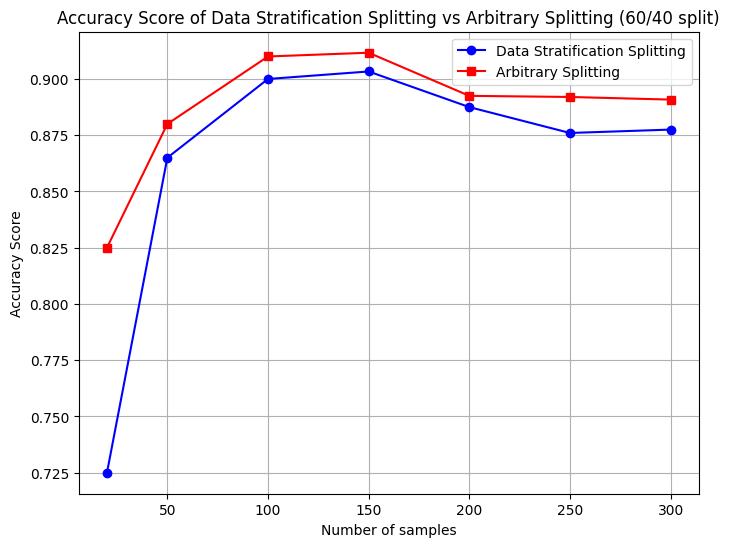

In [1753]:
plot_accuracy([0.725, 0.865, 0.9, 0.9033333333333333, 0.8875, 0.876, 0.8775], [0.825, 0.88, 0.91, 0.9116666666666666, 0.8925, 0.892, 0.8908333333333334], "Data Stratification Splitting", "Arbitrary Splitting", "60/40")

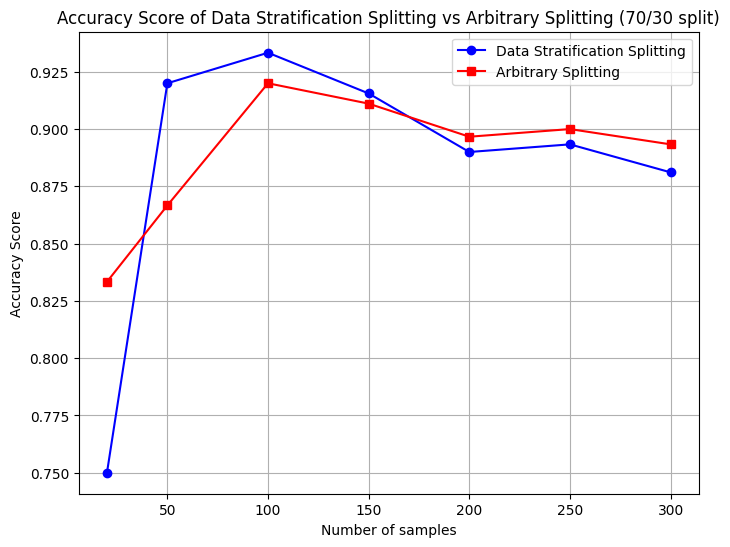

In [1754]:
plot_accuracy([0.75, 0.92, 0.9333333333333333, 0.9155555555555556, 0.89, 0.8933333333333333, 0.8811111111111111], [0.83333333, 0.8666666666666667, 0.92, 0.9111111111111111, 0.8966666666666666, 0.9, 0.8933333333333333], "Data Stratification Splitting", "Arbitrary Splitting", "70/30")

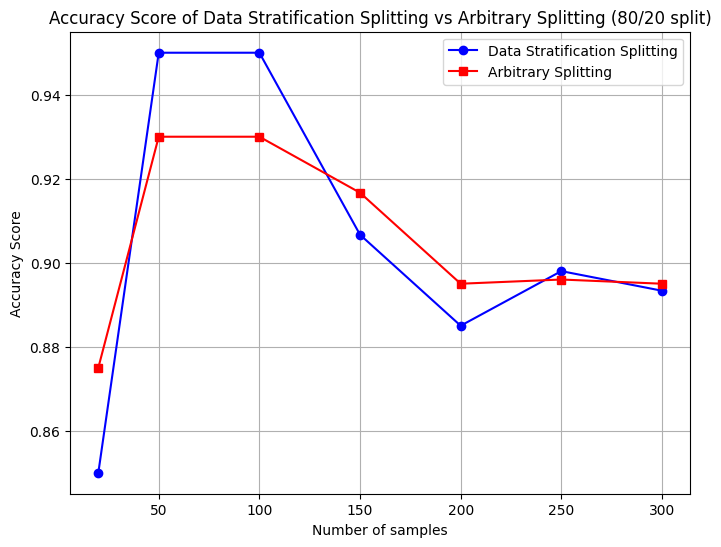

In [1755]:
plot_accuracy([0.85, 0.95, 0.95, 0.9066666666666666, 0.885, 0.898, 0.8933333333333333], [0.875, 0.93, 0.93, 0.9166666666666666, 0.895, 0.896, 0.895], "Data Stratification Splitting", "Arbitrary Splitting", "80/20")

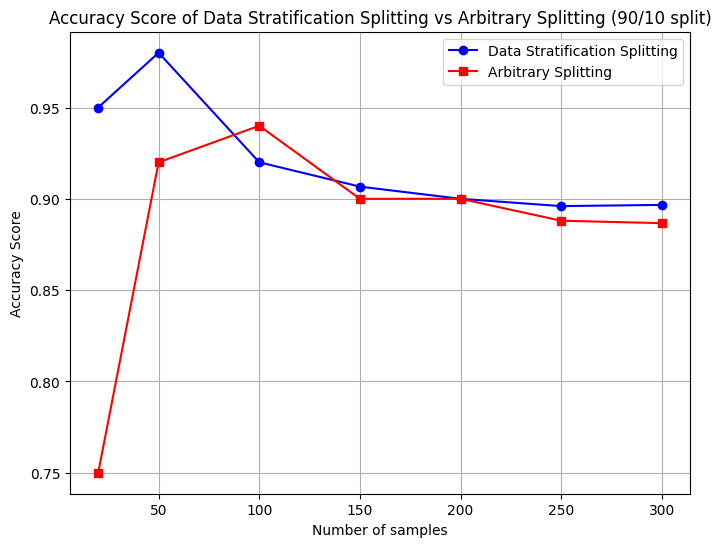

In [1756]:
plot_accuracy([0.95, 0.98, 0.92, 0.9066666666666666, 0.9, 0.896, 0.8966666666666666], [0.75, 0.92, 0.94, 0.9, 0.9, 0.888, 0.8866666666666667], "Data Stratification Splitting", "Arbitrary Splitting", "90/10")

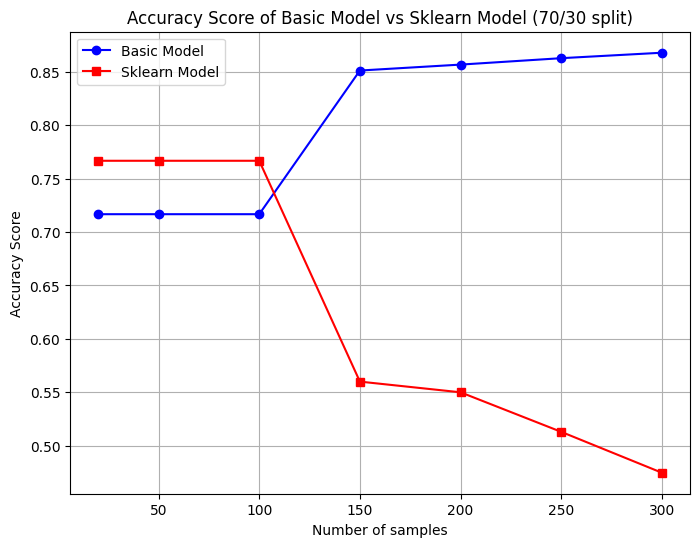

In [1757]:
plot_accuracy([0.716666666, 0.71666666, 0.716666666, 0.85111111, 0.856666667, 0.86266666, 0.86777777777], [0.76666667, 0.76666667, 0.7666667, 0.56, 0.55, 0.513, 0.47474], "Basic Model", "Sklearn Model", "70/30")

#### Confusion Matrix

In [1758]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [1759]:
def plot_conf_matrix(true, predicted, modelname):
    cm = confusion_matrix(true, predicted)
    labels = np.unique(true)
    fig, ax = plt.subplots(figsize=(8, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(ax=ax, cmap='Blues')

    plt.title(f"Confusion Matrix for {modelname} (30 Samples 70/30 Split)")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show()

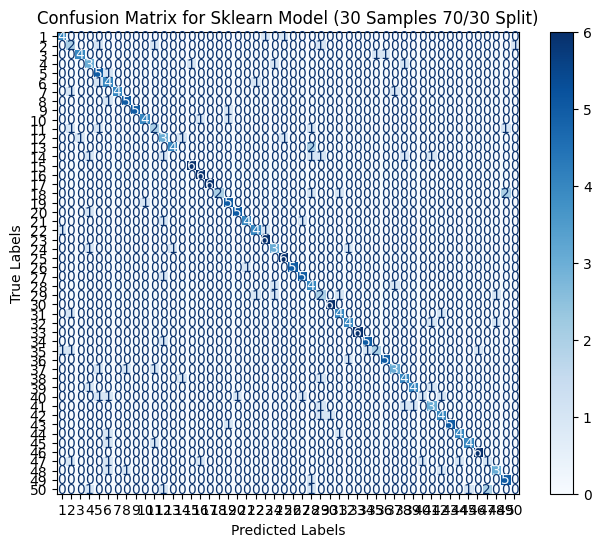

In [1760]:
plot_conf_matrix(test_label, skpredictions, "Sklearn Model")

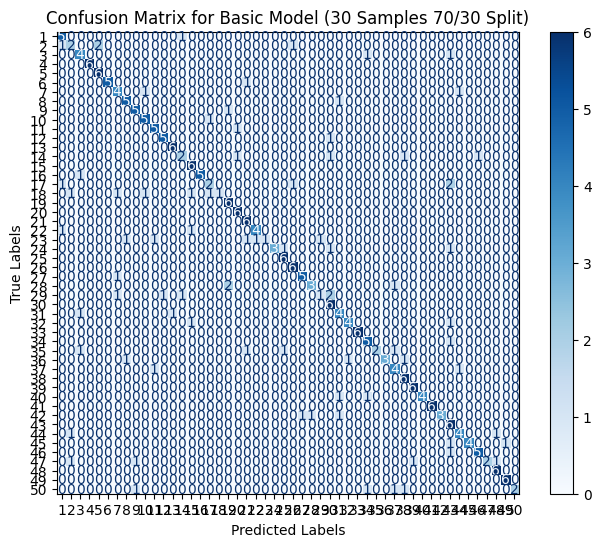

In [1761]:
plot_conf_matrix(test_label, basicpredictions, "Basic Model")

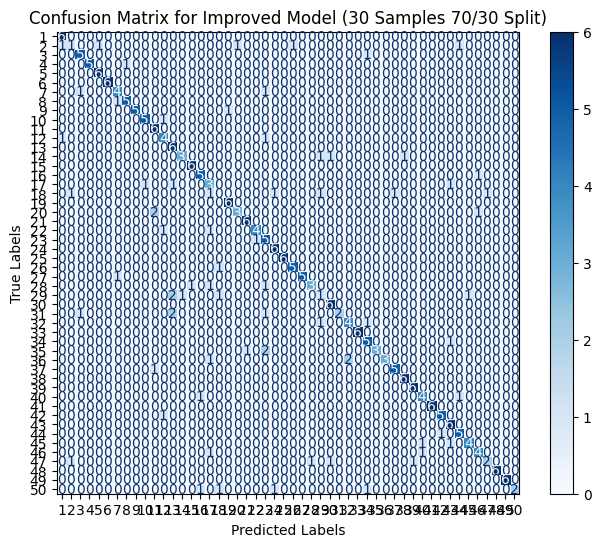

In [1762]:
plot_conf_matrix(test_label, improvedpredictions, "Improved Model")